# Make dataset

In [1]:
# Autorelaod
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import igraph as ig
import leidenalg
from scipy.special import softmax
import re
from statsmodels.stats.multitest import multipletests
import ast

os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf

config_file="/home/gdallagl/myworkdir/ESMSec/config/config.yaml"
config = mf.load_config(config_file)

mf.set_all_seeds(config["random_seed"])

Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
Seeds set successfully to 42 for random, numpy, and PyTorch (if used).


# Load Uniprot proteins

In [2]:
proteome_uniprot = pd.read_csv(config["data_paths"]["human_proteome_uniprot"])
display(proteome_uniprot.head(3))

# Define proteins to use in the follwing analasys
ALLOWED_PROTEINS = set(proteome_uniprot.Entry)
print("Number allowed proteins: ", len(ALLOWED_PROTEINS))
print(*list(ALLOWED_PROTEINS)[:10], "...")

,Entry,Reviewed,Gene Names (primary),Gene Names,Organism,Length,Subcellular location [CC],Gene Ontology (cellular component),Sequence,IsIsoform
0,Q8WZ42,reviewed,TTN,TTN,Homo sapiens (Human),34350,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000305|P...,condensed nuclear chromosome [GO:0000794]; cyt...,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,False
1,Q8WXI7,reviewed,MUC16,MUC16 CA125,Homo sapiens (Human),14507,SUBCELLULAR LOCATION: Cell membrane; Single-pa...,external side of plasma membrane [GO:0009897];...,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,False
2,Q9H195,reviewed,MUC3B,MUC3B,Homo sapiens (Human),13477,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,Golgi lumen [GO:0005796]; plasma membrane [GO:...,MQLLGLLSILWMLKSSPGATGTLSTATSTSHVTFPRAEATRTALSN...,False


Number allowed proteins:  20210
P0DMN0 O60343 Q86XX4 P48549 A0A1W2PPH5 P22460 Q8NHM4 A5PLN9 Q6UXL0 P23471 ...


# Load definitive positive genes

In [3]:
#positive_genes_path = config["data_paths"]["final_positive_genes"]
positive_genes_path = '/home/gdallagl/myworkdir/ESMSec/data/cell_location/nucleus-speckle_Uniprot-locations_02_positive_proteins.csv'
positive_genes_df = pd.read_csv(positive_genes_path)
INITIAL_POSITIVE_GENES = set(positive_genes_df[positive_genes_df.definitive_positive == "positive"].gene)

# Save dataset name for later
dataset_name = "_".join(positive_genes_path.split("/")[-1].split("_")[:2])
print(dataset_name)

# Give protein names to genes usiong unirpto df
# REMOVE not allowed proteins
positive_genes_df = positive_genes_df.merge(proteome_uniprot[["Gene Names (primary)", "Entry"]], how="inner", left_on="gene", right_on="Gene Names (primary)")
positive_genes_df.rename(columns={"Entry": "protein"}, inplace=True)

print("Positive genes df with mapped proteins")
display(positive_genes_df)

# List of geenes
POSITIVE_PROTEINS = set(positive_genes_df[positive_genes_df.definitive_positive == "positive"].protein)
AMBIGUOS_PROTEINS = set(positive_genes_df[positive_genes_df.definitive_positive == "ambiguous"].protein)
print("Number initial positive genes", len(INITIAL_POSITIVE_GENES))
print("Number positive proteins", len(POSITIVE_PROTEINS))
print("Number ambiguos proteins", len(AMBIGUOS_PROTEINS))

nucleus-speckle_Uniprot-locations
Positive genes df with mapped proteins


,gene,definitive_positive,geneset_count,Uniprot-locations,Gene Names (primary),protein
0,SRRM2,positive,1,"{'nucleus speckle', 'nucleus'}",SRRM2,Q9UQ35
1,TENM1,ambiguous,1,"{'cytoplasm', 'nucleus speckle', 'cytoskeleton...",TENM1,Q9UKZ4
2,SON,positive,1,{'nucleus speckle'},SON,P18583
3,PRPF8,positive,1,"{'nucleus speckle', 'nucleus'}",PRPF8,Q6P2Q9
4,ASCC3,positive,1,"{'cytosol', 'nucleus speckle', 'cytoplasm', 'n...",ASCC3,Q8N3C0
...,...,...,...,...,...,...
198,NXT1,positive,1,"{'nucleus speckle', 'cytoplasm', 'nucleus'}",NXT1,Q9UKK6
199,CBY1,positive,1,"{'cytoplasm', 'cilium', 'flagellum', 'golgi ap...",CBY1,Q9Y3M2
200,PHF5A,positive,1,"{'nucleus speckle', 'nucleus'}",PHF5A,Q7RTV0
201,TCIM,positive,1,"{'nucleolus', 'cytoplasm', 'nucleus speckle', ...",TCIM,Q9NR00


Number initial positive genes 187
Number positive proteins 187
Number ambiguos proteins 16


# Mapping positive-protein --> number genesets

For sampling prob later

In [4]:
tmp = positive_genes_df[positive_genes_df["definitive_positive"] == "positive"]
positive_protein_freq_map = dict(zip(tmp["protein"], tmp["geneset_count"]))
print(positive_protein_freq_map)

{'Q9UQ35': 1, 'P18583': 1, 'Q6P2Q9': 1, 'Q8N3C0': 1, 'P49750': 1, 'Q14966': 1, 'Q9UPS6': 1, 'Q9H2Y7': 1, 'Q14997': 1, 'Q69YN4': 1, 'O15047': 1, 'Q92766': 1, 'Q5T200': 1, 'Q8NI27': 1, 'Q14004': 1, 'Q9NYV4': 1, 'Q9UKV3': 1, 'P51816': 1, 'O75533': 1, 'O15357': 1, 'Q03112': 1, 'Q86Z02': 1, 'Q6PD62': 1, 'Q9H7Z3': 1, 'Q8IZL2': 1, 'Q96JK9': 1, 'Q96SB8': 1, 'Q8WWM7': 1, 'Q9P2N5': 1, 'P42285': 1, 'Q7L014': 1, 'Q92585': 1, 'Q9NRA8': 1, 'Q96T37': 1, 'Q15020': 1, 'O75400': 1, 'Q9Y2W1': 1, 'P52824': 1, 'O94906': 1, 'Q9NYF8': 1, 'Q9HCG8': 1, 'Q8IYB3': 1, 'Q13435': 1, 'Q8NDT2': 1, 'Q9H6E5': 1, 'Q6NWY9': 1, 'Q99814': 1, 'Q86YF9': 1, 'Q9BZJ0': 1, 'P49756': 1, 'Q16665': 1, 'Q00839': 1, 'O75152': 1, 'Q8TF01': 1, 'Q99459': 1, 'Q8WTT2': 1, 'Q68CJ6': 1, 'Q15459': 1, 'Q86TB9': 1, 'Q13627': 1, 'Q9H1I8': 1, 'Q13427': 1, 'Q8NHY2': 1, 'Q96MU7': 1, 'Q9H307': 1, 'O00213': 1, 'P23246': 1, 'O15234': 1, 'Q02040': 1, 'P78362': 1, 'Q5TEA6': 1, 'O43395': 1, 'Q9Y2N7': 1, 'Q9P0U4': 1, 'O75925': 1, 'Q9BTA9': 1, 'Q9ULX6': 1

# Load Uniref50 Clusters

In [5]:
# Load already preprocessed version
uniref_df = pd.read_csv(config["data_paths"]["uniref_df_path"])

# Make columsn lsits and not jsut stirngs
uniref_df["protein"] = uniref_df["protein"].apply(ast.literal_eval)
uniref_df["gene"] = uniref_df["gene"].apply(ast.literal_eval)

# Filter allowed poteins
uniref_df["proteins_positive"], uniref_df["genes_positive"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if p in ALLOWED_PROTEINS],
        [g for p, g in zip(row["protein"], row["gene"]) if p in ALLOWED_PROTEINS],
    ),
    axis=1
))

print(uniref_df.shape)
uniref_df.head(3)

(19012, 7)


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive
0,UniRef50_Q86YD7,"[Q86YD7, Q658T7, A0A8V8TPE2, A8MXJ8, A6NKC0, A...","[FAM90A1, FAM90A2P, FAM90A3, FAM90A5, FAM90A7,...",22,22,"[Q86YD7, Q658T7, A0A8V8TPE2, A8MXJ8, A6NKC0, A...","[FAM90A1, FAM90A2P, FAM90A3, FAM90A5, FAM90A7,..."
1,UniRef50_Q6R6M4,"[Q7RTZ2, Q6R6M4, A6NCW0, A6NCW7, A8MUK1, P0C7H...","[USP17L1, USP17L2, USP17L3, USP17L4, USP17L5, ...",19,19,"[Q7RTZ2, Q6R6M4, A6NCW0, A6NCW7, A8MUK1, P0C7H...","[USP17L1, USP17L2, USP17L3, USP17L4, USP17L5, ..."
2,UniRef50_Q13066,"[A6NGK3, Q4V321, Q6NT46, Q13066, Q4V326, P0DTW...","[GAGE10, GAGE13, GAGE2A, GAGE2B, GAGE2E, GAGE1...",17,17,"[A6NGK3, Q4V321, Q6NT46, Q13066, Q4V326, P0DTW...","[GAGE10, GAGE13, GAGE2A, GAGE2B, GAGE2E, GAGE1..."


## Mark positive genes and clusters

In [6]:
# Add the 'label' column: 'positive' if at least one protein maps to a positive gene, otherwise 'negative'
uniref_df["cluster_label"] = uniref_df["protein"].apply(
    lambda protein_list:
    "positive" if any(p in POSITIVE_PROTEINS for p in protein_list)
    else "negative"
)

# plot how many postive genesets
print(uniref_df["cluster_label"].value_counts())#.sort_index().plot(kind="bar", logy=True,)

cluster_label
negative    18826
positive      186
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,n_proteins_positive
404,UniRef50_Q15233,"[Q15233, Q8WXF1]","[NONO, PSPC1]",2,2,"[Q15233, Q8WXF1]","[NONO, PSPC1]",positive,2,2
13463,UniRef50_O60828,[O60828],[PQBP1],1,1,[O60828],[PQBP1],positive,1,1
16395,UniRef50_Q5HYJ3,[Q5HYJ3],[FAM76B],1,1,[Q5HYJ3],[FAM76B],positive,1,1
15000,UniRef50_Q14966,[Q14966],[ZNF638],1,1,[Q14966],[ZNF638],positive,1,1
14416,UniRef50_Q2TAY7,[Q2TAY7],[SMU1],1,1,[Q2TAY7],[SMU1],positive,1,1


(19012, 10)

<Axes: xlabel='n_genes_positive'>

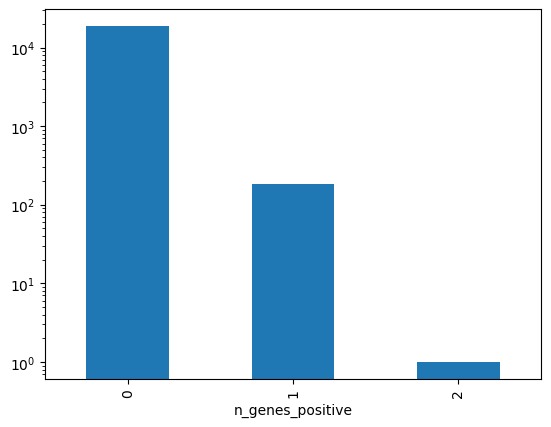

In [7]:
# create list of genes AND CORREPSONDET prots that are postive (from above)
# NEED POSITIVE GENES FOR ENRICHEMENT ANALSYS

# unzip in parallel pritens_clened and genes_clened and create ritens_clened_psotive and genes_clened_positive 
    # maintain if proteins comes form psotive gene
uniref_df["proteins_positive"], uniref_df["genes_positive"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if p in POSITIVE_PROTEINS], # protein is postive based on gene
        [g for p, g in zip(row["protein"], row["gene"]) if p in POSITIVE_PROTEINS], # protein is postive based on gene
    ),
    axis=1
))
uniref_df["n_genes_positive"] = uniref_df["genes_positive"].apply(len)
uniref_df["n_proteins_positive"] = uniref_df["proteins_positive"].apply(len)
uniref_df.sort_values(by="n_genes_positive", ascending=False, inplace=True)

display(uniref_df.head(5))
display(uniref_df.shape)
uniref_df.n_genes_positive.value_counts().plot(kind="bar", logy=True)

## Give probs to positive genes

In [8]:
# give probablities to be samped to each protein
uniref_df["logits"] = uniref_df["proteins_positive"].apply(
    lambda gene_list: [positive_protein_freq_map.get(g, 0) for g in gene_list]
)
def safe_softmax(logits):
    if len(logits) == 0:
        return []  # return empty list if no logits
    return softmax(logits).tolist()  # convert numpy array to list
uniref_df["probs"] = uniref_df["logits"].apply(safe_softmax)

uniref_df.head(2)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,n_proteins_positive,logits,probs
404,UniRef50_Q15233,"[Q15233, Q8WXF1]","[NONO, PSPC1]",2,2,"[Q15233, Q8WXF1]","[NONO, PSPC1]",positive,2,2,"[1, 1]","[0.5, 0.5]"
13463,UniRef50_O60828,[O60828],[PQBP1],1,1,[O60828],[PQBP1],positive,1,1,[1],[1.0]


# Mark NEGATIVE proteins

Create a list for each cluster that contains genes that are negative. 

We will sample from this list later to create the negative class.

We define a negative gene as:

- they cant be positive genes
- they cant be ambiguos genes
- OPTIONAL: many proteins of same class but still differt (ex. odoranr receptros)
    - SOLUTION: solve wht pfam and interpro domains --> group proteins that have same domains --> take only one from the group

In [9]:
# Start with all proteins in uniref_df
PUTATIVE_NEGATIVE_PROTEINS = set().union(*uniref_df.protein)
print(len(PUTATIVE_NEGATIVE_PROTEINS))

# Remove positve and ambibuos
PUTATIVE_NEGATIVE_PROTEINS = PUTATIVE_NEGATIVE_PROTEINS.difference(POSITIVE_PROTEINS)
print(len(PUTATIVE_NEGATIVE_PROTEINS))
PUTATIVE_NEGATIVE_PROTEINS = PUTATIVE_NEGATIVE_PROTEINS.difference(AMBIGUOS_PROTEINS)
print(len(PUTATIVE_NEGATIVE_PROTEINS))


20207
20020
20004


### Optional: Remove duplicated protein domains

In [10]:
# interpro_df = pd.read_csv(config["data_paths"]["interprot_domains"], sep="\t")

# def extract_ids(cell, prefix):
#     if pd.isna(cell):
#         return []
#     # Find all matches like PFxxxxx or IPRxxxxx
#     ids = re.findall(rf"{prefix}\d+", cell)
#     return list(set(ids))  # optional: remove duplicates

# # Apply parsing
# interpro_df["Pfam_list"] = interpro_df["Pfam"].apply(lambda x: extract_ids(str(x), "PF"))
# interpro_df["InterPro_list"] = interpro_df["InterPro"].apply(lambda x: extract_ids(str(x), "IPR"))

# interpro_df["n_Pfam"] = interpro_df["Pfam_list"].apply(len)
# interpro_df["n_InterPro"] = interpro_df["InterPro_list"].apply(len)

# interpro_df["all_domains"] = interpro_df.apply(lambda row: set(row['Pfam_list']) | set(row['InterPro_list']), axis=1)

# interpro_df

In [11]:
# # Filter to current subset of prots
# interpro_df = interpro_df[interpro_df.Entry.isin(putative_negative_protein_gene_df.protein.to_list())]

# # Convert sets to frozensets for grouping (sets aren't hashable)
# interpro_df['domains_hashable'] = interpro_df['all_domains'].apply(frozenset)

# # Group by domains and aggregate
# final_groups_df = (
#     interpro_df[interpro_df.duplicated(subset=['domains_hashable'], keep=False)] #keep=False, mark all pccurencies
#     .groupby('domains_hashable')['Entry']  # group by set of domains
#     .agg(Proteins_in_Group=list, Group_Size='size')
#         #Collect all the protein_id values in the group into a list
#         #'size'	Count how many items are in the group
#     .reset_index()
#     .sort_values('Group_Size', ascending=False)
# )

# # Convert frozensets back to sets for display
# final_groups_df['all_domains'] = final_groups_df['domains_hashable'].apply(set)
# final_groups_df = final_groups_df.drop(columns=['domains_hashable'])

# display(final_groups_df)

# # Clean up the temporary column
# interpro_df = interpro_df.drop(columns=['domains_hashable'])
# interpro_df = interpro_df.drop_duplicates(subset="all_domains")

# # Filter df
# putative_negative_protein_gene_df = putative_negative_protein_gene_df[putative_negative_protein_gene_df.protein.isin(interpro_df.Entry.to_list())]

# print("Remained proteins:", len(putative_negative_protein_gene_df))

### Optional: subsample to remove proteins with overlapping domains

In [12]:
# # Flatten the Jaccard matrix (exclude diagonal if it's 1.0 self-similarity)
# jaccard_values = jaccard_matrix[np.triu_indices_from(jaccard_matrix, k=1)]  # Upper triangle only
# jaccard_values = jaccard_values[jaccard_values != 0]

# # Create histogram
# plt.figure(figsize=(10, 6))
# plt.hist(jaccard_values, bins=100, edgecolor='black', alpha=0.7)
# plt.xlabel('Jaccard Similarity', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.title('Distribution of Jaccard Similarities', fontsize=14)
# plt.grid(axis='y', alpha=0.3)

# # Add statistics
# mean_val = np.mean(jaccard_values)
# median_val = np.median(jaccard_values)
# plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
# plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')
# plt.legend()

# # Print summary statistics
# print("Jaccard Similarity Statistics:")
# print(f"Min: {jaccard_values.min():.4f}")
# print(f"Max: {jaccard_values.max():.4f}")
# print(f"Mean: {mean_val:.4f}")
# print(f"Median: {median_val:.4f}")
# print(f"Std: {np.std(jaccard_values):.4f}")

In [13]:
# # Create edge list using SIMILARITY (Jaccard) as weights
# # Leiden with ModularityVertexPartition: higher weight = stronger connection
# threshold = median_val  # Minimum Jaccard similarity to create an edge

# edges = []
# weights = []
# for i in range(len(jaccard_df)):
#     for j in range(i+1, len(jaccard_df)):
#         similarity = jaccard_matrix[i, j]
#         if similarity > threshold:  # Use similarity directly
#             edges.append((i, j))
#             weights.append(similarity)  # Higher Jaccard = stronger edge

# # Create igraph
# g = ig.Graph(n=len(jaccard_df), edges=edges)
# g.es['weight'] = weights

# # Run Leiden clustering
# partition = leidenalg.find_partition(
#     g, 
#     leidenalg.ModularityVertexPartition,
#     weights='weight',
#     n_iterations=-1,  # Run until convergence
#     seed=42 
# )

# # Add cluster labels to dataframe
# interpro_df['Leiden_Cluster'] = partition.membership

# for i, g in interpro_df.groupby(['Leiden_Cluster']):
#     print("Cluster name", i, "Lenght:", len(g))
#     display("Memebers:", g.Entry.unique())
#     if i[0] == 0:
#         break

# print(f"\nNumber of clusters: {len(set(partition.membership))}")
# print(f"Modularity: {partition.modularity:.3f}")
# print(f"\nCluster sizes:")
# display(interpro_df['Leiden_Cluster'].value_counts().sort_index())

# # Check for singletons (clusters with only 1 member)
# cluster_sizes = interpro_df['Leiden_Cluster'].value_counts()
# singletons = cluster_sizes[cluster_sizes == 1]
# print(f"\nSingletons (clusters of size 1): {len(singletons)}")

In [14]:
# # retain onlyu one prot form each cluster
# interpro_df_filtered = interpro_df.drop_duplicates(subset=["Leiden_Cluster"]).copy()
# display(interpro_df_filtered)

# # Filter df
# putative_negative_protein_gene_df = putative_negative_protein_gene_df[putative_negative_protein_gene_df.protein.isin(interpro_df_filtered.Entry.to_list())]
# display(putative_negative_protein_gene_df)


## Prepare col where to sample negatives

In [15]:
# Create list of putative negative genes/protein        
    # ATTENTION; putatove = neither postive neither ambigous
uniref_df["putative_negative_proteins"], uniref_df["putative_negative_genes"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if p in PUTATIVE_NEGATIVE_PROTEINS],
        [g for p, g in zip(row["protein"], row["gene"]) if p in PUTATIVE_NEGATIVE_PROTEINS],
    ),
    axis=1
))
# count
uniref_df["n_putative_negative_proteins"] = uniref_df.putative_negative_proteins.apply(len)

# ATTENTION: same NEGATIVE clusters coudl have 0 proteins
# necause all proteins are postive OR ambigous so nothing left to sample as negative)

display(uniref_df.head(5))


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,n_proteins_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_proteins
404,UniRef50_Q15233,"[Q15233, Q8WXF1]","[NONO, PSPC1]",2,2,"[Q15233, Q8WXF1]","[NONO, PSPC1]",positive,2,2,"[1, 1]","[0.5, 0.5]",[],[],0
13463,UniRef50_O60828,[O60828],[PQBP1],1,1,[O60828],[PQBP1],positive,1,1,[1],[1.0],[],[],0
16395,UniRef50_Q5HYJ3,[Q5HYJ3],[FAM76B],1,1,[Q5HYJ3],[FAM76B],positive,1,1,[1],[1.0],[],[],0
15000,UniRef50_Q14966,[Q14966],[ZNF638],1,1,[Q14966],[ZNF638],positive,1,1,[1],[1.0],[],[],0
14416,UniRef50_Q2TAY7,[Q2TAY7],[SMU1],1,1,[Q2TAY7],[SMU1],positive,1,1,[1],[1.0],[],[],0


# *) Are there enriched clusters?

fraction_positive
0.0    18826
0.5        4
1.0      182
Name: count, dtype: int64


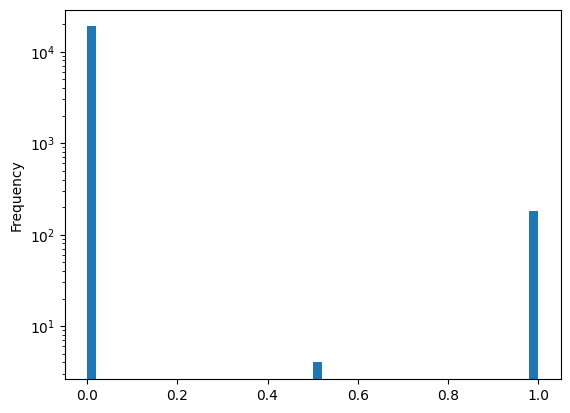

In [16]:
# FRACTION OF CLUSTER OCCUPIED BY POSITIVE GENES
uniref_df["fraction_positive"] = uniref_df.n_genes_positive / uniref_df.n_genes
uniref_df.sort_values(by="fraction_positive", inplace=True, ascending=False)

# hsit
uniref_df.fraction_positive.plot(kind="hist", logy=True, bins=50)
print(uniref_df.fraction_positive.value_counts().sort_index())


In [17]:
# HYPERGEMOETRIC TEST

# Filter genesets with enough genes
    # ATTENTION
    # CANNOT USE TOO SMALL DRAWING (n) --> test power comes from the changing probabilities over several draws, known as sampling without replacemen
uniref_df_big = uniref_df[uniref_df.n_genes >= 1].copy()

# Define background
total_genes = len(set().union(*uniref_df_big["gene"]))
total_positive = len(set().union(*uniref_df_big["genes_positive"]))
print(f"Unique total genes: {total_genes}")
print(f"Unique total positive genes: {total_positive}")

# Run enrichment test
results = uniref_df_big.apply(
    lambda row: pd.Series(
        dataf.per_cluster_hypergeom_test(
            row["n_genes"], 
            row["n_genes_positive"], 
            total_genes, 
            total_positive
        )
    ), 
    axis=1
)
results.columns = ["enrichment_prob", "enrichment_pvalue"]

# Combine results
df_uniref_enriched = pd.concat([uniref_df_big, results], axis=1)
df_uniref_enriched = df_uniref_enriched.sort_values("enrichment_pvalue")

# Multiple testing correction (FDR)
df_uniref_enriched["enrichment_pvalue_adj"] = multipletests(
    df_uniref_enriched["enrichment_pvalue"], 
    method="fdr_bh"
)[1]
df_uniref_enriched["significant"] = df_uniref_enriched["enrichment_pvalue_adj"] < 0.05

# Summary
print(f"\nSignificant enriched gene sets: {df_uniref_enriched['significant'].sum()} / {len(df_uniref_enriched)}")
display(
    df_uniref_enriched[
        ["UniRef50_Cluster", "n_genes", "n_genes_positive", 
         "enrichment_prob", "enrichment_pvalue", 
         "enrichment_pvalue_adj", "significant"]
    ].head(10)
)

# only enriched
df_uniref_significant = df_uniref_enriched[df_uniref_enriched['significant'] == True]

Unique total genes: 20207
Unique total positive genes: 187

Significant enriched gene sets: 0 / 19012


,UniRef50_Cluster,n_genes,n_genes_positive,enrichment_prob,enrichment_pvalue,enrichment_pvalue_adj,significant
404,UniRef50_Q15233,2,2,0.000085,0.000085,0.96671,False
14249,UniRef50_O43395,1,1,0.009254,0.009254,0.96671,False
15381,UniRef50_Q15459,1,1,0.009254,0.009254,0.96671,False
8364,UniRef50_Q99459,1,1,0.009254,0.009254,0.96671,False
18927,UniRef50_Q00839,1,1,0.009254,0.009254,0.96671,False
7220,UniRef50_Q9UQ35,1,1,0.009254,0.009254,0.96671,False
1309,UniRef50_Q8NHY2,1,1,0.009254,0.009254,0.96671,False
17140,UniRef50_P57052,1,1,0.009254,0.009254,0.96671,False
17717,UniRef50_P48729,1,1,0.009254,0.009254,0.96671,False
6897,UniRef50_Q9UKV3,1,1,0.009254,0.009254,0.96671,False


# Create Dataset

## Positive class sampling

In [18]:
# Filter only positive clusters
uniref_df_pos = uniref_df[uniref_df.cluster_label == "positive"].copy()

# sample or take all postive proteins?
if not config["dataset_creation"]["sample_positive_genes"]:
    SAMPLE_N_POSITIVE = uniref_df_pos.n_proteins_positive.max() # the number to sample is the max possbile
else:
    SAMPLE_N_POSITIVE = config["dataset_creation"]["number_positive_proteins_to_sample_per_cluster"]

uniref_df_pos["proteins_sampled"], uniref_df_pos["genes_sampled"] = zip(
    *uniref_df_pos.apply(
            dataf.sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=SAMPLE_N_POSITIVE, 
            gene_col="genes_positive",  # ATTENTION_: sample from correct columns --> the psotive gene here
            prot_col="proteins_positive", 
            probs_col="probs")
)
uniref_df_pos["n_proteins_sampled"] = uniref_df_pos.proteins_sampled.apply(len)

display(uniref_df_pos.head(2))
print(uniref_df_pos.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,n_proteins_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_proteins,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
14249,UniRef50_O43395,[O43395],[PRPF3],1,1,[O43395],[PRPF3],positive,1,1,[1],[1.0],[],[],0,1.0,[O43395],[PRPF3],1
8364,UniRef50_Q99459,[Q99459],[CDC5L],1,1,[Q99459],[CDC5L],positive,1,1,[1],[1.0],[],[],0,1.0,[Q99459],[CDC5L],1


(186, 19)


## Negative Sampling

- do not use clusters that are negative but have 0 negative prots (ex all are ambiguos)
- do not take neagtive proteins that come form psotive lcusters (even if the single proteins are negative)
- sample proteins wiht uniform distr

In [19]:
# Filter only negative clusters
    # sample from clusters that do nto contain psotive (negative label of before)
uniref_df_neg = uniref_df[
    (uniref_df.n_putative_negative_proteins > 0) & # some lcuster maybe haev only ambigus genes
    (uniref_df.cluster_label == "negative") # avoid proteins from proteins class are used as eagtive
    ].copy() 

# Sample or nor sample?
if config["dataset_creation"]["sample_negative_genes"]:
    print("Sampling negative class")
    
    uniref_df_neg["proteins_sampled"], uniref_df_neg["genes_sampled"] = zip(
        *uniref_df_neg.apply(
                dataf.sample_sampled_from_single_row, 
                axis=1, 
                min_sample_n=SAMPLE_N_POSITIVE, 
                gene_col="putative_negative_genes",  # ATTENTION
                prot_col="putative_negative_proteins", 
                probs_col=None # uniform
                )
    )
else:
    uniref_df_neg["proteins_sampled"], uniref_df_neg["genes_sampled"] = uniref_df_neg["putative_negative_proteins"], uniref_df_neg["putative_negative_genes"] 

uniref_df_neg["n_proteins_sampled"] = uniref_df_neg.proteins_sampled.apply(len)

# ATTENTION: same clusters coudl have 0 proteins to sample from (all proteins are postive OR ambigous so nothing left to sample as negative)
uniref_df_neg = uniref_df_neg[uniref_df_neg.n_proteins_sampled > 0]

display(uniref_df_neg.head())
print(uniref_df_neg.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,n_proteins_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_proteins,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
115,UniRef50_P18669,"[P18669, P15259, Q8N0Y7]","[PGAM1, PGAM2, PGAM4]",3,3,[],[],negative,0,0,[],[],"[P18669, P15259, Q8N0Y7]","[PGAM1, PGAM2, PGAM4]",3,0.0,"[P18669, P15259, Q8N0Y7]","[PGAM1, PGAM2, PGAM4]",3
117,UniRef50_Q9UDX3,"[Q9UDX4, Q9UDX3, B5MCN3]","[SEC14L3, SEC14L4, SEC14L6]",3,3,[],[],negative,0,0,[],[],"[Q9UDX4, Q9UDX3, B5MCN3]","[SEC14L3, SEC14L4, SEC14L6]",3,0.0,"[Q9UDX4, Q9UDX3, B5MCN3]","[SEC14L3, SEC14L4, SEC14L6]",3
118,UniRef50_A6NM11,"[A6NMS7, A6NM11, O60309]","[LRRC37A, LRRC37A2, LRRC37A3]",3,3,[],[],negative,0,0,[],[],"[A6NMS7, A6NM11, O60309]","[LRRC37A, LRRC37A2, LRRC37A3]",3,0.0,"[A6NMS7, A6NM11, O60309]","[LRRC37A, LRRC37A2, LRRC37A3]",3
73,UniRef50_P17024,"[Q8NDP4, Q7L945, C9JN71, P17024]","[ZNF439, ZNF627, ZNF878, ZNF20]",4,4,[],[],negative,0,0,[],[],"[Q8NDP4, Q7L945, C9JN71, P17024]","[ZNF439, ZNF627, ZNF878, ZNF20]",4,0.0,"[Q8NDP4, Q7L945, C9JN71, P17024]","[ZNF439, ZNF627, ZNF878, ZNF20]",4
120,UniRef50_Q15155,"[Q15155, Q5JPE7, P69849]","[NOMO1, NOMO2, NOMO3]",3,3,[],[],negative,0,0,[],[],"[Q15155, Q5JPE7, P69849]","[NOMO1, NOMO2, NOMO3]",3,0.0,"[Q15155, Q5JPE7, P69849]","[NOMO1, NOMO2, NOMO3]",3


(18810, 19)


## Make dataset

- concat pos and neg
- expand to have

| Cluster | protein name | label | seq |

In [20]:
# add labels
uniref_df_pos["label_single_prot"] = 1 # all the sample dproteins in a cluster eceive the same label --> cannot have 2 differt labels in same clustr
uniref_df_neg["label_single_prot"] = 0

# merge --> each entry is a cluster
dataset_df = pd.concat([uniref_df_pos, uniref_df_neg])
display(dataset_df.head())
display(dataset_df.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,n_proteins_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_proteins,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled,label_single_prot
14249,UniRef50_O43395,[O43395],[PRPF3],1,1,[O43395],[PRPF3],positive,1,1,[1],[1.0],[],[],0,1.0,[O43395],[PRPF3],1,1
8364,UniRef50_Q99459,[Q99459],[CDC5L],1,1,[Q99459],[CDC5L],positive,1,1,[1],[1.0],[],[],0,1.0,[Q99459],[CDC5L],1,1
15381,UniRef50_Q15459,[Q15459],[SF3A1],1,1,[Q15459],[SF3A1],positive,1,1,[1],[1.0],[],[],0,1.0,[Q15459],[SF3A1],1,1
17140,UniRef50_P57052,[P57052],[RBM11],1,1,[P57052],[RBM11],positive,1,1,[1],[1.0],[],[],0,1.0,[P57052],[RBM11],1,1
19002,UniRef50_Q02040,[Q02040],[AKAP17A],1,1,[Q02040],[AKAP17A],positive,1,1,[1],[1.0],[],[],0,1.0,[Q02040],[AKAP17A],1,1


(18996, 20)

In [21]:
# Create long df

# smaller df
cols_to_keep = ['UniRef50_Cluster', 'proteins_sampled',
                'genes_sampled', 'label_single_prot']
dataset_df_small = dataset_df[cols_to_keep].copy()

# Create a new DataFrame where each row corresponds to a (protein, gene) pair
rows = []
for _, row in dataset_df_small.iterrows():
    cluster = row["UniRef50_Cluster"] # single vlaue
    label = row["label_single_prot"] # single value
    proteins = row["proteins_sampled"] # list
    genes = row["genes_sampled"] # list

    # zip ensures 1-to-1 pairing between proteins and genes
    for prot, gene in zip(proteins, genes):
        rows.append({
            "UniRef50_Cluster": cluster,
            "protein": prot,
            "gene": gene,
            "label": label
        })

df_long = pd.DataFrame(rows)

print("ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins")
print(df_long.protein.nunique(), "/", proteome_uniprot.shape[0])

# checj fro duplcates
print("\nDuplicated rows/proteins: ", df_long.shape[0] - df_long.protein.nunique())

df_long

ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins
20187 / 20210

Duplicated rows/proteins:  0


,UniRef50_Cluster,protein,gene,label
0,UniRef50_O43395,O43395,PRPF3,1
1,UniRef50_Q99459,Q99459,CDC5L,1
2,UniRef50_Q15459,Q15459,SF3A1,1
3,UniRef50_P57052,P57052,RBM11,1
4,UniRef50_Q02040,Q02040,AKAP17A,1
...,...,...,...,...
20182,UniRef50_Q03111,Q03111,MLLT1,0
20183,UniRef50_Q03060,Q03060,CREM,0
20184,UniRef50_Q03052,Q03052,POU3F1,0
20185,UniRef50_Q03014,Q03014,HHEX,0


## Assure 1:N ratio in postive:negative class
After previos sampling sampling you will have
- | pos prot | << | neg prot | → more thna 1:3 ration
- Need to subsampled negative class
- Subsample negative class
    - Subsample the remaining cluster to have a final ratio 1:3

In [22]:
if config["dataset_creation"]["sample_negative_genes"]:
    print("Sampling")
    
    # list of smpled positve proteins
    positive_proteins_tmp = set(df_long[df_long.label == 1]["protein"].unique())

    # list of prtein in MIXED cluster (wiht inside btoh postive and negative prteins)
        # ATTENTUON: check no ptortien in mixed clusters
    proteins_in_mixed_clusters = df_long.groupby('UniRef50_Cluster').filter(lambda x: x['label'].nunique() > 1).sort_values(by="UniRef50_Cluster")
    print("priteins in mixed clusters:", len(proteins_in_mixed_clusters))
    proteins_in_mixed_clusters = set(proteins_in_mixed_clusters["protein"].unique())

    # proteins to NOT remove
    proteins_not_to_remove = proteins_in_mixed_clusters.union(positive_proteins_tmp)

    # give col
    df_long["can_be_removed"] = ~df_long["protein"].isin(proteins_not_to_remove)


    # decide fraction to susample

    # Number of positive proteins
    n_positive = df_long[df_long["label"] == 1].shape[0]
    # Number desidered negative
    n_desired_negatives = n_positive * config["dataset_creation"]["mult_factor_negative_class"]
    # Removable (negative) proteins
    removable_negatives = df_long[(df_long["label"] == 0) & (df_long["can_be_removed"])]
    # Determine fraction to subsample
    frac_to_sample = n_desired_negatives / len(removable_negatives)
    frac_to_sample = min(frac_to_sample, 1.0)  # cannot sample more than available

    frac_to_sample


    # susample
    removable = df_long[df_long["can_be_removed"]]
    keep = df_long[~df_long["can_be_removed"]]

    subsampled_removable = removable.sample(frac=frac_to_sample)

    df_subsampled = pd.concat([keep, subsampled_removable]).reset_index(drop=True) # Combine back with the protected proteins

else:
    df_subsampled = df_long.copy()

print(df_subsampled.label.value_counts())
df_subsampled

label
0    20000
1      187
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,label
0,UniRef50_O43395,O43395,PRPF3,1
1,UniRef50_Q99459,Q99459,CDC5L,1
2,UniRef50_Q15459,Q15459,SF3A1,1
3,UniRef50_P57052,P57052,RBM11,1
4,UniRef50_Q02040,Q02040,AKAP17A,1
...,...,...,...,...
20182,UniRef50_Q03111,Q03111,MLLT1,0
20183,UniRef50_Q03060,Q03060,CREM,0
20184,UniRef50_Q03052,Q03052,POU3F1,0
20185,UniRef50_Q03014,Q03014,HHEX,0


## Give Sequence


In [23]:
### create df to join
join_df_tmp = proteome_uniprot[["Entry", "Sequence"]].copy().rename(columns={"Sequence": "sequence"})

# join
    # ATTNETION: we shoudl NOT lose any col
long_df_seq = pd.merge(how="inner", left=df_subsampled, right=join_df_tmp, left_on="protein", right_on="Entry")

# drp cols
long_df_seq.drop(columns=["Entry"], inplace=True)

long_df_seq

,UniRef50_Cluster,protein,gene,label,sequence
0,UniRef50_O43395,O43395,PRPF3,1,MALSKRELDELKPWIEKTVKRVLGFSEPTVVTAALNCVGKGMDKKK...
1,UniRef50_Q99459,Q99459,CDC5L,1,MPRIMIKGGVWRNTEDEILKAAVMKYGKNQWSRIASLLHRKSAKQC...
2,UniRef50_Q15459,Q15459,SF3A1,1,MPAGPVQAVPPPPPVPTEPKQPTEEEASSKEDSAPSKPVVGIIYPP...
3,UniRef50_P57052,P57052,RBM11,1,MFPAQEEADRTVFVGNLEARVREEILYELFLQAGPLTKVTICKDRE...
4,UniRef50_Q02040,Q02040,AKAP17A,1,MAAATIVHDTSEAVELCPAYGLYLKPITKMTISVALPQLKQPGKSI...
...,...,...,...,...,...
20182,UniRef50_Q03111,Q03111,MLLT1,0,MDNQCTVQVRLELGHRAQLRKKPTTEGFTHDWMVFVRGPEQCDIQH...
20183,UniRef50_Q03060,Q03060,CREM,0,MTMETVESQHDGSITASLTESKSAHVQTQTGQNSIPALAQVSVAGS...
20184,UniRef50_Q03052,Q03052,POU3F1,0,MATTAQYLPRGPGGGAGGTGPLMHPDAAAAAAAAAAAERLHAGAAY...
20185,UniRef50_Q03014,Q03014,HHEX,0,MQYPHPGPAAGAVGVPLYAPTPLLQPAHPTPFYIEDILGRGPAAPT...


## Stratify dataset

We can stratify based on many metrics:
1. labels
2. PREVALENT metric
3. **based on cluster**
    - Put proteins coming from same cluster in different sets or not

In [24]:
from sklearn.model_selection import train_test_split
import pandas as pd

# --- group-level stratified split ---

# pslit by cluster and then ive back set-label to each row

# One representative row per UniRef50_Cluster
cluster_df = long_df_seq.groupby('UniRef50_Cluster').first().reset_index()

# Stratified split by label, but at the cluster level
    # ists of unique cluster IDs.
train_clusters, temp_clusters = train_test_split(
    cluster_df['UniRef50_Cluster'],
    test_size=0.2,
    stratify=cluster_df['label'],
    random_state=42
)

# Split the temporary set equally into validation and test
temp_labels = cluster_df.loc[cluster_df['UniRef50_Cluster'].isin(temp_clusters), 'label']
val_clusters, test_clusters = train_test_split(
    temp_clusters,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

# --- assign back to the full dataframe ---
#Every row in long_df_seq inherits its set label based on its UniRef50_Cluster
long_df_seq['set'] = ''
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(train_clusters), 'set'] = 'train'
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(test_clusters), 'set'] = 'test'

# ATTENTION: ingore val
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(val_clusters), 'set'] = 'val'
long_df_seq.loc[long_df_seq['set'] == "val", 'set'] = 'test'
long_df_seq.loc[long_df_seq.loc[long_df_seq['set'] == 'test'].index[0], 'set'] = 'val' 

# Check split distribution
print(long_df_seq.groupby('set')['label'].value_counts().unstack(fill_value=0))
display(long_df_seq)


label      0    1
set              
test    4005   36
train  15995  150
val        0    1


,UniRef50_Cluster,protein,gene,label,sequence,set
0,UniRef50_O43395,O43395,PRPF3,1,MALSKRELDELKPWIEKTVKRVLGFSEPTVVTAALNCVGKGMDKKK...,val
1,UniRef50_Q99459,Q99459,CDC5L,1,MPRIMIKGGVWRNTEDEILKAAVMKYGKNQWSRIASLLHRKSAKQC...,train
2,UniRef50_Q15459,Q15459,SF3A1,1,MPAGPVQAVPPPPPVPTEPKQPTEEEASSKEDSAPSKPVVGIIYPP...,test
3,UniRef50_P57052,P57052,RBM11,1,MFPAQEEADRTVFVGNLEARVREEILYELFLQAGPLTKVTICKDRE...,train
4,UniRef50_Q02040,Q02040,AKAP17A,1,MAAATIVHDTSEAVELCPAYGLYLKPITKMTISVALPQLKQPGKSI...,train
...,...,...,...,...,...,...
20182,UniRef50_Q03111,Q03111,MLLT1,0,MDNQCTVQVRLELGHRAQLRKKPTTEGFTHDWMVFVRGPEQCDIQH...,test
20183,UniRef50_Q03060,Q03060,CREM,0,MTMETVESQHDGSITASLTESKSAHVQTQTGQNSIPALAQVSVAGS...,train
20184,UniRef50_Q03052,Q03052,POU3F1,0,MATTAQYLPRGPGGGAGGTGPLMHPDAAAAAAAAAAAERLHAGAAY...,train
20185,UniRef50_Q03014,Q03014,HHEX,0,MQYPHPGPAAGAVGVPLYAPTPLLQPAHPTPFYIEDILGRGPAAPT...,train


# Checks

In [25]:
# All intial psotive genes are presnet?
missing_pos_genes = INITIAL_POSITIVE_GENES - set(uniref_df.gene.explode())
print(missing_pos_genes)

# All uniprot protein have been used?
    # most probably they are 
        # 1. ambigus proteins
        # 2. neagtive protein in positive vluster, so they cant have been sampled
        # 3. not present inn any uniref cluster
unused_proteins = set(proteome_uniprot.Entry).difference(long_df_seq.protein)
unused_minus_ambiguos = unused_proteins.difference(AMBIGUOS_PROTEINS)
prot_neg_in_pos_cluster = set(uniref_df.loc[uniref_df.protein.apply(lambda x: bool(set(x) & unused_proteins)), 'putative_negative_proteins'].explode())
unsued_minus_prot_neg_in_pos_cluster = unused_proteins.difference(prot_neg_in_pos_cluster)
all_uniref = set(uniref_df.protein.explode())
unsued_minus_all_uniref = unused_proteins.difference(all_uniref)
#uniref_df[uniref_df.protein.apply(lambda x: len(set(x).intersection(unused_proteins)) > 0)]

print(unused_proteins)
print(unused_minus_ambiguos)
print(unsued_minus_prot_neg_in_pos_cluster)
print(unsued_minus_all_uniref)

# duplicated proteins?
display(long_df_seq.protein.value_counts().loc[lambda x: x > 1])

# Have we really removed ambogus proteins
print(AMBIGUOS_PROTEINS.intersection(long_df_seq.protein))
print("P13727" in set(long_df_seq.protein))


uniref_df[uniref_df.protein.apply(lambda x: len(set(x).intersection(prot_neg_in_pos_cluster)) > 0)]

set()
{'P49761', 'Q9NQ29', 'Q3ZCQ8', 'P02545', 'Q9H2U1', 'P27695', 'Q9UKZ4', 'Q12972', 'Q8IZP6', 'Q6K0P9', 'Q8IZD2', 'P0DOY5', 'P0DPI4', 'Q96SB4', 'Q96FV9', 'Q9GZY0', 'Q6PJT7', 'P49760', 'P19544', 'O15527', 'P0DPR3', 'Q8TDX7', 'Q86XP3'}
{'Q9NQ29', 'Q8IZP6', 'P0DPR3', 'Q8TDX7', 'P0DOY5', 'P0DPI4', 'Q9GZY0'}
{'P49761', 'Q3ZCQ8', 'P02545', 'Q9H2U1', 'P27695', 'Q9UKZ4', 'Q12972', 'Q6K0P9', 'Q8IZD2', 'P0DOY5', 'Q96FV9', 'P0DPI4', 'Q96SB4', 'Q6PJT7', 'P49760', 'P19544', 'O15527', 'P0DPR3', 'Q86XP3'}
{'P0DPR3', 'P0DPI4', 'P0DOY5'}


Series([], Name: count, dtype: int64)

set()
True


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,n_proteins_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_proteins,fraction_positive
229,UniRef50_Q9Y383,"[Q9Y383, Q9NQ29]","[LUC7L2, LUC7L]",2,2,[Q9Y383],[LUC7L2],positive,1,1,[1],[1.0],[Q9NQ29],[LUC7L],1,0.5
634,UniRef50_Q9UBU9,"[Q9UBU9, Q9GZY0]","[NXF1, NXF2]",2,2,[Q9UBU9],[NXF1],positive,1,1,[1],[1.0],[Q9GZY0],[NXF2],1,0.5
430,UniRef50_Q9HC98,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2,2,[Q9HC98],[NEK6],positive,1,1,[1],[1.0],[Q8TDX7],[NEK7],1,0.5
495,UniRef50_O15541,"[O15541, Q8IZP6]","[RNF113A, RNF113B]",2,2,[O15541],[RNF113A],positive,1,1,[1],[1.0],[Q8IZP6],[RNF113B],1,0.5


# Save

In [26]:
save_path = os.path.join(
    os.path.dirname(positive_genes_path),
    f"{dataset_name}_03_dataset_final_sample-neg={config['dataset_creation']['sample_negative_genes']}.csv"
)
long_df_seq.to_csv(save_path, index=False)

print(save_path)

/home/gdallagl/myworkdir/ESMSec/data/cell_location/nucleus-speckle_Uniprot-locations_03_dataset_final_sample-neg=False.csv
